In [1]:
from typing import Callable, Iterator, Sequence
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from jax_diffusion.types import Config, Params, Rng, ndarray

import jax.numpy as jnp
import jax.scipy as jsp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm

In [2]:
def generate_checkerboard(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/malbergo/stochastic-interpolants/blob/main/notebooks/checker-mirror.ipynb
    x1 = rng.uniform(size=num) * 4 - 2
    x2_ = rng.uniform(size=num) - rng.choice([0, 1], size=(num,)) * 2
    x2 = x2_ + (np.floor(x1) % 2)
    x = np.hstack([x1[:, None], x2[:, None]]) * 2
    return x

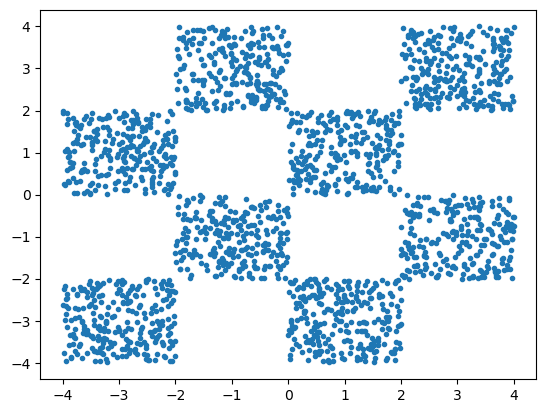

In [3]:
X_train = generate_checkerboard(num=2000, rng=np.random.default_rng())
plt.plot(X_train[:, 0], X_train[:, 1], '.')

In [4]:
Activation = Callable[[jax.numpy.ndarray], jax.numpy.ndarray]

class DiffusionMLP(nn.Module):
    features: Sequence[int]
    activation: Activation = nn.relu

    @nn.compact
    def __call__(self, x: jax.numpy.ndarray) -> jax.numpy.ndarray:
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        
        # 输出参数以用于噪声模型
        noise_params = nn.Dense(1)(x)  # 假设输出为噪声方差的对数
        
        # 也可以输出中间状态 x_t（可选）
        x_t = nn.Dense(x.shape[-1])(x)
        
        return x_t, noise_params
    
model = DiffusionMLP(features=[64, 64, 64])
print(model.tabulate(jax.random.PRNGKey(0), jnp.zeros((1, 2))))



                                 MLP Summary                                  
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs        ┃ outputs        ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[1,2]  │ - float32[1,2] │                        │
│         │        │               │ - float32[1,1] │                        │
├─────────┼────────┼───────────────┼────────────────┼────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,2]  │ float32[1,64]  │ bias: float32[64]      │
│         │        │               │                │ kernel: float32[2,64]  │
│         │        │               │                │                        │
│         │        │               │                │ 192 (768 B)            │
├─────────┼────────┼───────────────┼────────────────┼────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,64] │ float32[1,64] 

In [ ]:
class Diffuser:
    def __init__(self, eps_fn, diffusion_config: Config):
        self.eps_fn = eps_fn
        self.config = diffusion_config
        self.betas = jnp.asarray(self._betas(**diffusion_config))
        self.alphas = jnp.asarray(self._alphas(self.betas))
        self.alpha_bars = jnp.asarray(self._alpha_bars(self.alphas))

    @property
    def steps(self) -> int:
        return self.config.T

    def timesteps(self, steps: int):
        timesteps = jnp.linspace(0, self.steps, steps + 1)
        timesteps = jnp.rint(timesteps).astype(jnp.int32)
        return timesteps[::-1]

    @partial(jax.jit, static_argnums=(0,))
    def forward(self, x_0: ndarray, rng: Rng):
        """See algorithm 1 in https://arxiv.org/pdf/2006.11239.pdf"""
        rng1, rng2 = random.split(rng)
        t = random.randint(rng1, (len(x_0), 1), 0, self.steps)
        x_t, eps = self.sample_q(x_0, t, rng2)
        t = t.astype(x_t.dtype)
        return x_t, t, eps

    def sample_q(self, x_0: ndarray, t: ndarray, rng: Rng):
        """Samples x_t given x_0 by the q(x_t|x_0) formula."""
        # (bs, 1)
        alpha_t_bar = self.alpha_bars[t]
        # (bs, 1, 1, 1)
        alpha_t_bar = jnp.expand_dims(alpha_t_bar, (1, 2))

        eps = random.normal(rng, shape=x_0.shape, dtype=x_0.dtype)
        x_t = (alpha_t_bar**0.5) * x_0 + ((1 - alpha_t_bar) ** 0.5) * eps
        return x_t, eps

    @partial(jax.jit, static_argnums=(0,))
    def ddpm_backward_step(self, params: Params, x_t: ndarray, t: int, rng: Rng):
        """See algorithm 2 in https://arxiv.org/pdf/2006.11239.pdf"""
        alpha_t = self.alphas[t]
        alpha_t_bar = self.alpha_bars[t]
        sigma_t = self.betas[t] ** 0.5

        z = (t > 0) * random.normal(rng, shape=x_t.shape, dtype=x_t.dtype)
        eps = self.eps_fn(params, x_t, t, train=False)

        x = (1 / alpha_t**0.5) * (
            x_t - ((1 - alpha_t) / (1 - alpha_t_bar) ** 0.5) * eps
        ) + sigma_t * z

        return x

    def ddpm_backward(self, params: Params, x_T: ndarray, rng: Rng) -> ndarray:
        x = x_T

        for t in range(self.steps - 1, -1, -1):
            rng, rng_ = random.split(rng)
            x = self.ddpm_backward_step(params, x, t, rng_)

        return x

    @partial(jax.jit, static_argnums=(0,))
    def ddim_backward_step(
        self, params: Params, x_t: ndarray, t: ndarray, t_next: ndarray
    ):
        """See section 4.1 and C.1 in https://arxiv.org/pdf/2010.02502.pdf

        Note: alpha in the DDIM paper is actually alpha_bar in DDPM paper
        """
        alpha_t = self.alpha_bars[t]
        alpha_t_next = self.alpha_bars[t_next]

        eps = self.eps_fn(params, x_t, t, train=False)

        x_0 = (x_t - (1 - alpha_t) ** 0.5 * eps) / alpha_t**0.5
        x_t_direction = (1 - alpha_t_next) ** 0.5 * eps
        x_t_next = alpha_t_next**0.5 * x_0 + x_t_direction

        return x_t_next

    def ddim_backward(self, params: Params, x_T: ndarray, steps: int):
        x = x_T

        ts = self.timesteps(steps)
        for t, t_next in zip(ts[:-1], ts[1:]):
            x = self.ddim_backward_step(params, x, t, t_next)

        return x

    @classmethod
    def _betas(cls, beta_1: float, beta_T: float, T: int) -> ndarray:
        return jnp.linspace(beta_1, beta_T, T, dtype=jnp.float32)

    @classmethod
    def _alphas(cls, betas) -> ndarray:
        return 1 - betas

    @classmethod
    def _alpha_bars(cls, alphas) -> ndarray:
        return jnp.cumprod(alphas)

    @staticmethod
    def expand_t(t: int, x: ndarray):
        return jnp.full((len(x), 1), t, dtype=x.dtype)

In [28]:
@jax.jit
def ddpm_training_step(batch: jax.Array, params: chex.ArrayTree, opt_state: optax.OptState, rng: jax.random.PRNGKey) -> Tuple[float, chex.ArrayTree, optax.OptState]:
    def loss_fn(params, x_0, rng):
        rng, rng_step = jax.random.split(rng)
        x_t, _ = model.apply(params, x_0)  # 现在假设模型输出 x_t
        x_0_recon = Diffuser.ddpm_backward(params, x_t, rng_step)  # 使用 Diffuser 进行反向过程
        return jnp.mean((x_0 - x_0_recon) ** 2)  # 损失函数为重建误差
    
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, rng)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# 初始化参数和优化器状态
optimizer = optax.adam(learning_rate=1e-3)
params = model.init(jax.random.PRNGKey(0), jnp.zeros((1, 2)))
opt_state = optimizer.init(params)

# 训练循环
losses = []
for _ in tqdm.tqdm(range(5000)):
    batch = next(bm)  # 从您的数据管理器获取批次
    loss, params, opt_state = ddpm_training_step(batch, params, opt_state)
    losses.append(loss)


In [30]:
# Haiku模型转换
model_transformed = hk.transform(lambda x: MLP(features=[64, 64, 64])(x))

# 定义随机密钥
rng_key = jax.random.PRNGKey(0)
input_shape = (1, 2)  # 假设输入形状为 (1, 2)

# 初始化模型
model = MLP(features=[64, 64, 64])
params = model.init(rng_key, jnp.zeros(input_shape))['params']

# 初始化参数
rng_key = jax.random.PRNGKey(0)
# 初始化优化器
optimizer = optax.adam(learning_rate=1e-3)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))


In [32]:
@jax.jit
def train_step(params, opt_state, batch, rng_key):
    """单步训练函数"""
    # 计算损失函数的梯度
    loss_fn = lambda params: log_likelihood_loss(params, model, batch, rng_key)
    grads = jax.grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state


# 训练参数
num_epochs = 10
batch_size = 128
num_batches = X_train.shape[0] // batch_size

# 训练循环
for epoch in range(num_epochs):
    rng_key, subkey = jax.random.split(rng_key)
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = batch_start + batch_size
        batch = X_train[batch_start:batch_end]
        params, opt_state = train_step(params, opt_state, batch, subkey)
    print(f"Epoch {epoch+1} completed")


ScopeCollectionNotFound: Tried to access "kernel" from collection "params" in "/Dense_0" but the collection is empty. (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeCollectionNotFound)